In [1]:
# import lib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
# Define label
labels = ['correct mask', 'incorrect mask', 'not mask']

# Path load classifier face mask 
mask_classifier_path = './mask_classifier/best_model_xception_224x224_v1.h5'

# Load model mask classifier
mask_classifier = load_model(mask_classifier_path)

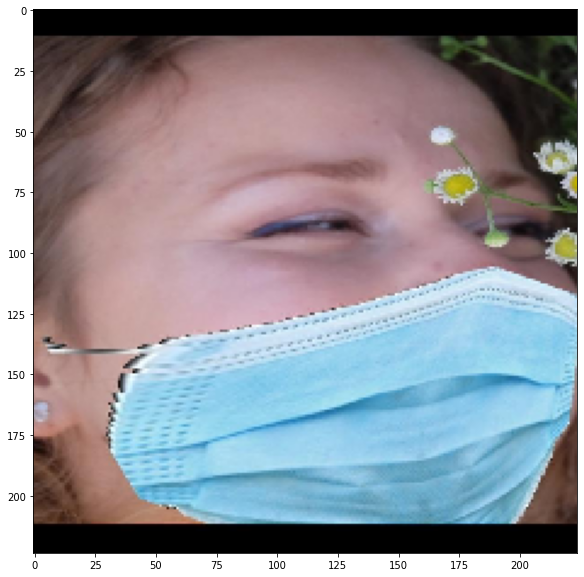

correct mask
99.98


In [3]:
#load the image
my_image = load_img("./datasets/processed/correct_mask/03802_Mask.jpg", target_size=(224, 224))

plt.figure(figsize=(10, 10))
plt.imshow(my_image)
plt.show()

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = mask_classifier.predict(my_image)
print(labels[np.argmax(prediction)])
print(round(np.max(prediction) * 100, 2))

In [4]:
# define variables for face detector 
labels = ['correct mask', 'incorrect mask', 'not mask']
prototxtPath = './face_detector/deploy.prototxt'
weightsPath = './face_detector/res10_300x300_ssd_iter_140000.caffemodel'
colors = [(0, 255, 0), (0, 255, 255), (0, 0, 255)]

In [5]:
# Load model mask classifier
mask_classifier = load_model(mask_classifier_path)

# Load model face detector
face_detector = cv2.dnn.readNet(prototxtPath, weightsPath)

In [6]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

def classify_face_mask(face_image_array, target_size=(224, 224)):
    face = cv2.cvtColor(face_image_array, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, target_size)
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    prediction = mask_classifier.predict(face)
    prob = round(np.max(prediction) * 100, 2)
    label = '{} : {}%'.format(labels[np.argmax(prediction)], prob)
    color = colors[np.argmax(prediction)]
    return label, prob, color

def detect_classify_face_mask(image_array):
    # get shape
    (h, w) = image.shape[:2]

    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (224, 224), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    print("[INFO] computing face detections...")
    face_detector.setInput(blob)
    detections = face_detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > .5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # face image array crop
            face = image[startY:endY, startX:endX]
            
            # get prediction
            label, prob, color = classify_face_mask(face)

            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    return image

[INFO] computing face detections...


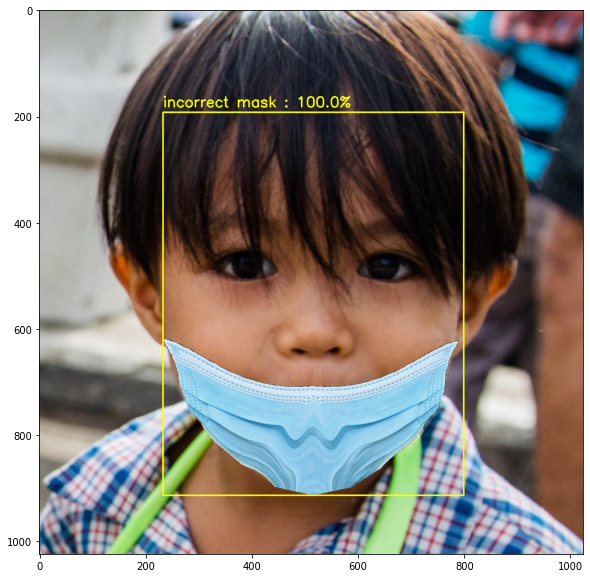

In [11]:
# try predict
image = cv2.imread('./datasets/original/incorrect_mask/00013_Mask_Mouth_Chin.jpg')
image = detect_classify_face_mask(image)
# display image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
# initialize the video stream and allow the camera sensor to warm up
import time
import imutils
from imutils.video import VideoStream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
# vs = cv2.VideoCapture('http://192.168.1.3:4343/video').start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=700)
    
    (h, w) = frame.shape[:2]
    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    face_detector.setInput(blob)
    detections = face_detector.forward()
    
    try:
        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is greater than the minimum confidence
            if confidence > .5:
                # compute the (x, y)-coordinates of the bounding box for the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                
                # ensure the bounding boxes fall within the dimensions of the frame
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # face image array crop
                face = frame[startY:endY, startX:endX]

                # get prediction
                label, prob, color = classify_face_mask(face)

                # display the label and bounding box rectangle on the output frame
                cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    except:
        continue
    
    # show the output frame
    cv2.imshow("Face Mask Detection", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...


In [19]:
cv2.destroyAllWindows()
vs.stop()